In [1]:
import cv2
import matplotlib.pyplot as plt

from trainer import *

import torch
from torchvision.models import resnet50, resnet18, resnext50_32x4d

WEIGHT_FILE = 'weights/resnet18_colour_1pen_scheduled_10e128bsMSE_Adam_weights_2022-08-03T153433.203190.pth'
model = resnet18(pretrained=False)
LOG_NAME = 'clip_model'
im_size = 256

num_classes = 2

# dynamically define whether to run on gpu or cpu
device_to_use = torch.device("cpu")

if torch.cuda.is_available():
    device_to_use = torch.device("cuda:0")
    print("Running on GPU")
else:
    print("Running on CPU")

c:\Users\gameg\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU


c:\Users\gameg\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\gameg\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:

# loading the model

# Get the number of inputs to the last fully connected layer in the model
num_ftrs = model.fc.in_features
# create a new final fully connected layer that we can train to replace the other fully connected layer
model.fc = nn.Linear(num_ftrs, num_classes)


# add the model to the device
model = model.to(device_to_use)

model.load_state_dict(torch.load(WEIGHT_FILE, map_location=device_to_use))

cow_model = Trainer(model, im_size, LOG_NAME, device_to_use=device_to_use)

cow_model.loss_function = nn.MSELoss()
cow_model.optimizer = optim.Adam(model.fc.parameters(), lr=cow_model.learning_rate)

print(f"Created {LOG_NAME}")

Created clip_model


In [3]:
# load the image and resize it
image = cv2.resize(cv2.imread('test.jpg'), (im_size, im_size))

# put the image into a format expected by the model
image = torch.from_numpy(image).float().permute(2,0,1).to(device_to_use).unsqueeze(0)

In [4]:
model.eval()

result = model(image)
print(result)

result = torch.argmax(result)

if result == 1:
    print('COW')
else:
    print('EMPTY')

tensor([[-29.6046,  53.2304]], device='cuda:0', grad_fn=<AddmmBackward0>)
COW


In [18]:
def clip_vid(video_path, model, step=24, val_step=2, im_size=256, allowed_error=8):
    
    # save the step value
    use_step = step

    # load the video from the path
    cap = cv2.VideoCapture(video_path)

    totalframecount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    clips = []

    prev_frame = False
    false_count = 0
    clip_i = 0

    # ret is a true or false value, false if no frame is returned
    for i in tqdm(range(totalframecount)):
        
        # every {step} frames
        if i % use_step == 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES,i)

            ret, frame = cap.read()

            # break if there's no frames left        
            if not ret:
                break

            frame = cv2.cvtColor(cv2.resize(frame, (im_size, im_size)), cv2.COLOR_BGR2RGB)

            # cv2.imshow('test', frame)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

            image = torch.from_numpy(frame).float().permute(2,0,1)

            if image.max() > 1:
                image = image/255.0

            result = torch.argmax(model(image.to(device_to_use).unsqueeze(0)))

            if result == 1:

                # if this is a new clip
                if not prev_frame:
                    clips.append([])
                    clip_i += 1

                    # update values
                    prev_frame = True
                    use_step = val_step
                    false_count = 0

                clips[clip_i].append(frame)
                  
            else:

                # only move on to new clip if its been more than 'allowed_error' frames false
                false_count += 1
                if false_count > allowed_error:
                    use_step = step
                    prev_frame = False
                

    print(len(clips), 'clips found')

    # only create a clip if theere are frames
    if len(clips) > 0:

        for i, clip in enumerate(clips):
            # writing 'clips' to video
            out = cv2.VideoWriter(f'clips/clip_{i}.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps / val_step, (im_size, im_size))

            # writing to the video
            for f in tqdm(clip):
                out.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))

            out.release()

    cap.release()   

In [19]:
clip_vid('F:/Deep Learning/drinking/videos_2/18-05-2022/110/MAH00034-0.mp4', model, step=180, val_step=12, im_size=256, allowed_error=24)

 24%|██▍       | 77760/321961 [00:08<00:27, 8905.88it/s]


IndexError: list index out of range

torch.Size([3, 256, 256])


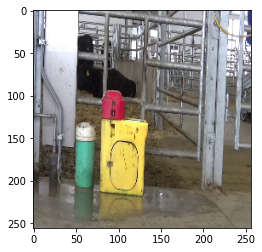

tensor([[0.9003, 0.1304]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
print(clip[0].shape)

plt.imshow(clip[0].permute(1, 2, 0))
plt.show()

result = model(clip[0].unsqueeze(0).to(device_to_use))
argresult = torch.argmax(result)

print(result)

In [5]:
def clip(path, model, step=24, im_size=256):

    # iterate over all the images in the directory
    # NOTE: tqdm is just a progress bar
    # NOTE: Folder format expected: VIDEOS/DD-MM-YYYY/pen(s)/vido_file.MP4
    for date in os.listdir(path):
        
        dir_date = date.replace('-', '/')
        print('\n\n'+dir_date)

        # all pens at date
        for pen in os.listdir(os.path.join(path, date)):
            
            # NOTE: don't include videos with multiple pens (for now)
            if '-' in pen:
                continue

            print('\t'+pen)
            
            # all videos at pen for that date
            for f in os.listdir(os.path.join(path, date, pen)):

                video_path = os.path.join(path, date, pen, f)

                # load the video from the path
                cap = cv2.VideoCapture(video_path)

                totalframecount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = cap.get(cv2.CAP_PROP_FPS)

                clips = []
                
                # writing 'clips' to video
                out = cv2.VideoWriter(f'clips/{f}_clip.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (im_size, im_size))

                # ret is a true or false value, false if no frame is returned
                for i in tqdm(range(totalframecount)):
                    
                    # every {step} frames
                    if i % step == 0:
                        ret, frame = cap.read()

                        # break if there's no frames left        
                        if not ret:
                            break

                        image = torch.from_numpy(cv2.resize(frame), (im_size, im_size)).float().permute(2,0,1).to(device_to_use).unsqueeze(0)

                        result = torch.argmax(model(image))
                        if result == 1:
                            out.write(image)
            
            cap.release()   